In [1]:
## This notebook describes how to generate timestreams from an instrument and a scanning strategy

In [2]:
## Include the path to instrument
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../s4cmb')))

from input_sky import HealpixFitsMap
from input_sky import create_sky_map
from input_sky import write_healpix_cmbmap
from instrument import hardware
from scanning_strategy import scanning_strategy
from tod import TimeOrderedData

import healpy as hp
import pylab as pl
import numpy as np

In [3]:
## Create a fake input
sky = create_sky_map('../data/test_data_set_lensedCls.dat', nside=128)
write_healpix_cmbmap(output_filename='mymaps.fits', data=sky, nside=128)

In [4]:
## Initialise our input maps
sky_in = HealpixFitsMap('mymaps.fits', do_pol=True, verbose=False, no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
inst = hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., FWHM=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_HWP='CRHWP', freq_HWP=2., angle_HWP=0., debug=False)

In [6]:
## Initialize our scanning strategy
scan = scanning_strategy(nCES=1, start_date='2013/1/1 00:00:00',
                 telescope_longitude='-67:46.816',
                 telescope_latitude='-22:56.396', telescope_elevation=5200.,
                 name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                 ut1utc_fn='../s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()

In [7]:
## Initialize our TOD (pointing)
tod = TimeOrderedData(inst, scan, sky_in)

In [8]:
tod.pointing.az

array([ 2.51491157,  2.51591929,  2.51692702, ...,  2.50382659,
        2.50483432,  2.50584204])

In [9]:
d = [tod.map2tod(i) for i in range(inst.focal_plane.nbolometer)]

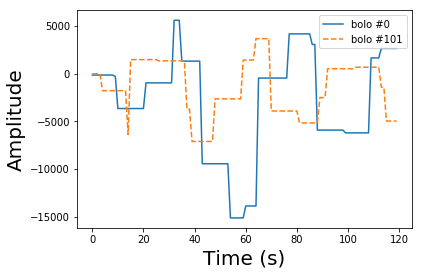

In [10]:
pl.plot(d[0][0:120], label='bolo #0')
pl.plot(d[101][0:120], ls='--', label='bolo #101')
pl.xlabel('Time (s)', fontsize=20)
pl.ylabel('Amplitude', fontsize=20)
pl.legend()
pl.show()

In [11]:
tod.tod2map_alldet(np.array(d),language='fortran')

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


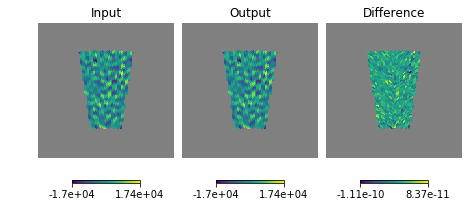

In [12]:
a = np.zeros(12*128**2)
hit = tod.nhit > 0
I = np.zeros_like(tod.d)
I[hit] = tod.d[hit] / tod.w[hit]
a[tod.obspix] = I
mask = a == 0
sky_in.I[mask] = np.nan
a[mask] = np.nan
hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=300, reso=6.9, sub=131, title='Input', notext=True)
hp.gnomview(a, rot=[0, -57.5], xsize=300, reso=6.9, sub=132, title='Output', notext=True)
hp.gnomview(sky_in.I - a, rot=[0, -57.5], xsize=300, reso=6.9, sub=133, title='Difference', notext=True)

pl.show()

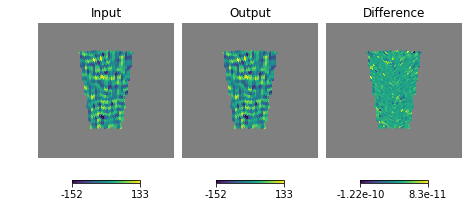

In [13]:
def QUsolve(dc, ds, cc, ss, cs):
    testcc = cc*ss - cs*cs
    idet = np.zeros(testcc.shape)
    inonzero = (testcc!=0.)
    idet[inonzero] = 1./testcc[inonzero]
    thresh = np.finfo(np.float32).eps
    try:
        izero = (np.abs(testcc)<thresh)
    except FloatingPointError:
        izero = inan = np.isnan(testcc)
        izero[~inan] = (np.abs(testcc[~inan])<thresh)
    idet[izero] = 0.0

    Q = idet*(ss*dc - cs*ds)
    U = idet*(-cs*dc + cc*ds)

    return Q,U
a = np.zeros(12*128**2)
Q, U = QUsolve(tod.dc, tod.ds, tod.cc, tod.ss, tod.cs)
a[tod.obspix] = Q
mask = a == 0
sky_in.Q[mask] = np.nan
a[mask] = np.nan

hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=300, reso=6.9, sub=131, title='Input', notext=True)
hp.gnomview(a, rot=[0, -57.5], xsize=300, reso=6.9, sub=132, title='Output', notext=True)
hp.gnomview(sky_in.Q - a, rot=[0, -57.5], xsize=300, reso=6.9, sub=133, title='Difference', notext=True)
pl.show()